In [15]:
import numpy as np

import os
import time
import pickle

import scipy.integrate as integrate
from scipy.optimize import minimize


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
def u_x(x, gamma=2.1, A=1.2):
    """
    Utility function for consumption of agent.
    """
    return A*x**(1-gamma) / (1-gamma)


def v_x(x, gamma=2.1):
    """
    Utility function for bequest of agent to offspring.
    """
    return x**(1-gamma) / (1-gamma)

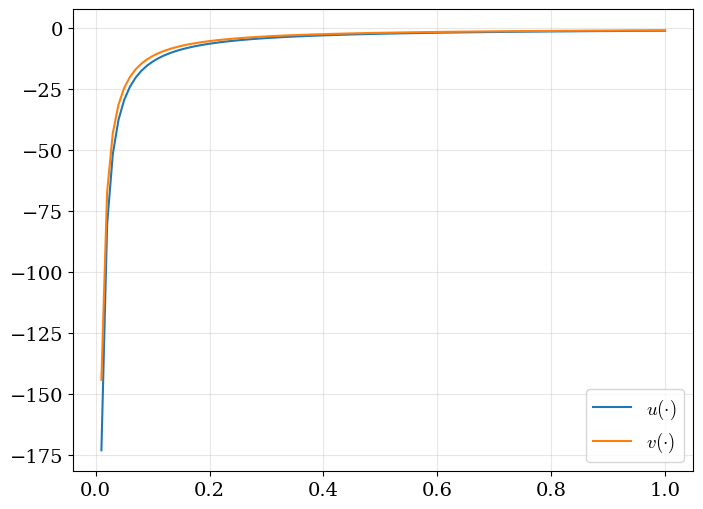

In [5]:
x = np.linspace(0.01, 1, 100)
y1 = u_x(x)
y2 = v_x(x)

plt.plot(x, y1, label=r"$u(\cdot)$")
plt.plot(x, y2, label=r"$v(\cdot)$")

plt.legend()
plt.show()

### Constants

In [62]:
gamma  = 2.1 # utility function parameter
A      = 1.2 # utility function parameter
r0     = 0.5 # left bound for uniform random return on project
r1     = 2.5 # right bound for uniform random return on project
r_hat  = 1.1 # safe return
I      = 1.0 # amount needed to undertake project
e_bar  = 1.5 # amount of entrepreneurial effort needed to undertake project
r_bar  = (1/(r1-r0)) * integrate.quad(lambda x: x, r0, r1)[0] # expected project return

### No project

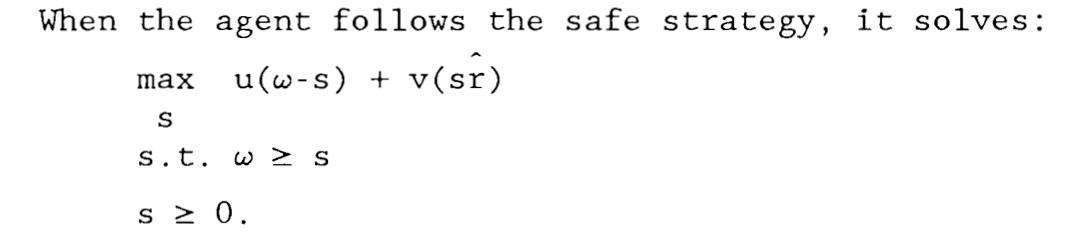

In [82]:
def consumption_utility(c, w):
    s = w-c
    return -(u_x(w-s) + v_x(s*r_hat))


def no_project_best_utility(w):
    result = minimize(consumption_utility, args=(w), bounds=((0,w),), x0=w/2, method="Powell")
    return -result.fun, result.x[0]

w = 0.1 | best utility = -51.254 	 (c = 0.05)
w = 0.5 | best utility = -8.727 	 (c = 0.27)
w = 0.8 | best utility = -5.204 	 (c = 0.43)
w = 1.5 | best utility = -2.606 	 (c = 0.80)


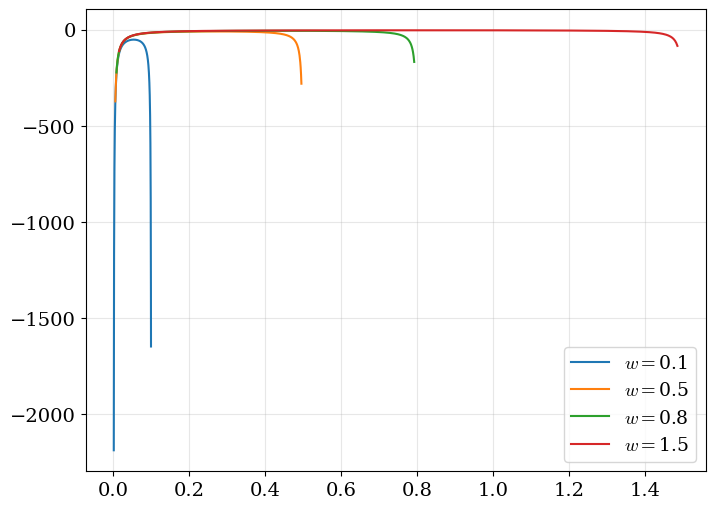

In [83]:
for w in [0.1, 0.5, 0.8, 1.5]:
    consumption_vals = np.linspace(w*0.01, w*0.99, 500)
    results = []
    for c in consumption_vals:
        s = w-c
        results.append(u_x(c) + v_x(s*r_hat))
    plt.plot(consumption_vals, results, label=r"$w=$" + str(w))
    print(f"w = {w:.1f} | best utility = {max(results):.3f} \t (c = {consumption_vals[np.argmax(results)]:.2f})")
plt.legend()
plt.show()

In [84]:
for w in [0.1, 0.5, 0.8, 1.5]:
    util, c = no_project_best_utility(w)
    print(f"w = {w:.1f} | best utility = {util:.4f}\t (c = {c:.3f})")

w = 0.1 | best utility = -51.2537	 (c = 0.053)
w = 0.5 | best utility = -8.7269	 (c = 0.267)
w = 0.8 | best utility = -5.2039	 (c = 0.427)
w = 1.5 | best utility = -2.6063	 (c = 0.801)


### Project

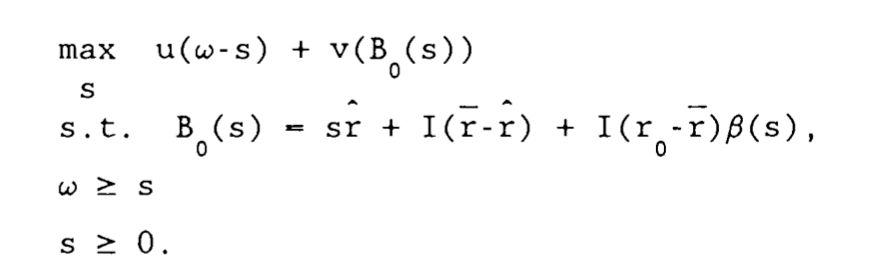

In [85]:
# dF(r) = F'(r)dr
# F(r) = (r-a)/(b-a), and so F'(r) = 1/(b-a)

In [86]:
def compute_beta_integral(beta, s):
    integral = (1/(r1-r0))*integrate.quad(lambda r: v_x(s*r_hat + I*(r_bar-r_hat) + I*beta*(r-r_bar)), r0, r1)[0]
    B0 =  s*r_hat + I*(r_bar-r_hat) + I*beta*(r0-r_bar)
    return integral - v_x(B0) - 1 # zeros of this function correspond to optimal beta


def find_optimal_beta(s, lower=0, upper=1, tolerance=1e-9, max_iters=80):
    iteration = 0
    while True:
        mid = (lower+upper)/2
        try:
            result = compute_beta_integral(mid, s)
        except:
            upper = 0.5
            continue
        if abs(result) < tolerance:
            break
        if result < 0:
            lower = mid
        elif result > 0:
            upper = mid
        iteration += 1
        if iteration > max_iters:
            return -1
    return mid


def beta_utility(s, w):
    beta = find_optimal_beta(float(s))
    B0 = s*r_hat + I*(r_bar-r_hat) + I*beta*(r0-r_bar)
    return - (u_x(w-s) + v_x(B0))


def project_best_utility(w):
    # optimal beta is defined for s in (0.0, 0.883)
    result = minimize(beta_utility, args=(w,), bounds=((0,min(w, 0.883)),), x0 = w/2)
    s = result.x[0]
    utility = result.fun[0] 
    return -utility, s, find_optimal_beta(float(s))

## Simulations

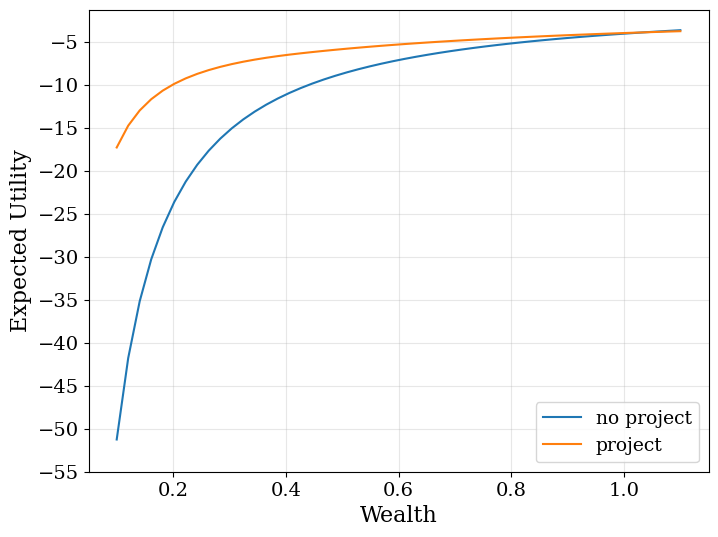

In [87]:
NP = []
P  = []

w_vals = np.linspace(0.1, 1.1, 50)

for wealth in w_vals:
    
    # project not undertaken
    utility_no_project, consumption_no_project = no_project_best_utility(wealth)
    NP.append(utility_no_project)

    # project undertaken
    utility_project, consumption_project, beta_project = project_best_utility(wealth)
    P.append(utility_project)
    
plt.plot(w_vals, NP, label="no project")
plt.plot(w_vals, P, label="project")

plt.yticks(np.linspace(-55, -5, 11))
plt.xlabel("Wealth")
plt.ylabel("Expected Utility")

plt.legend()
plt.show()

In [42]:
reps        = 25000
random_vals = np.random.uniform(r0, r1, size=reps)

wealth = 0.1
lineage_wealth = [wealth]

for rep_idx, rep in enumerate(range(reps)):
    if (rep) % (reps / 10) == 0:
        print(rep/reps)

    # project not undertaken
    utility_no_project, consumption_no_project = no_project_best_utility(wealth)

    # project undertaken
    utility_project, s, beta = project_best_utility(wealth)
    consumption_project = wealth-s
    
    if utility_project > utility_no_project:
        wealth = (wealth - consumption_project)*r_hat + I*(r_bar-r_hat) + I*beta*(random_vals[rep_idx]-r_bar)
    else:
        wealth = (wealth - consumption_no_project)*r_hat
        
    wealth = round(wealth,3)
        
    lineage_wealth.append(wealth)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


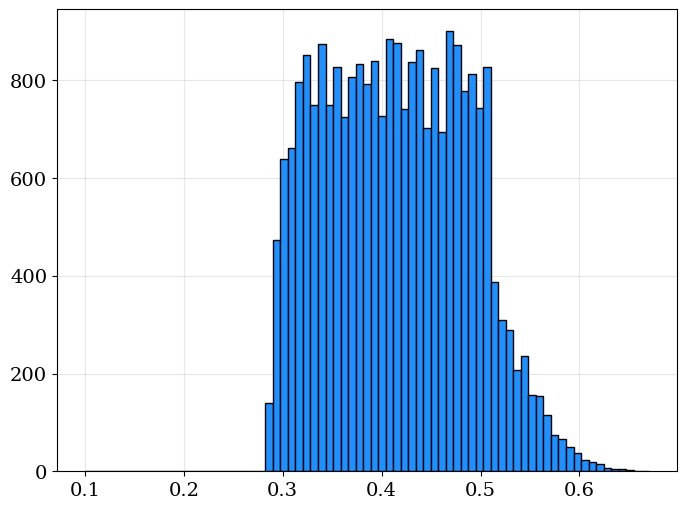

In [46]:
plt.hist(lineage_wealth, bins=75, color="dodgerblue", edgecolor="k")
plt.show()